In [19]:
import pandas as pd
import os

use_small_train = True

personal_path = "/vol/home/s4316061/CV_assignments/3_assign/"
if use_small_train:
    train_path_of_choice = "jester-v1-small-train.csv"
    data_download_path = 'downloaded_data_small/small-20bn-jester-v1/'
else:
    train_path_of_choice = "jester-v1-train.csv"
    data_download_path = 'something_else_entirely'
    
# valid is the same, regardless of the train set

train = pd.read_csv(personal_path + train_path_of_choice, sep=';', header=None, names=['id', 'gesture'])
valid = pd.read_csv(personal_path + "jester-v1-validation.csv", sep=';', header=None, names=['id', 'gesture'])

# get all the directory names of the subdirectories available (data is in 'big_dir/many_small_dirs/actual_images' format)
root = personal_path + data_download_path
subdir_set = {entry.name for entry in os.scandir(root) if entry.is_dir()}

print(train.shape[0] + valid.shape[0])  # sanity check These numbers should match, withing a reasonable degree
print(len(subdir_set)) 

# concatenating the DataFrames for easy querying
train_and_valid = pd.concat([train, valid], axis=0, ignore_index=True)

available_ids = set(train_and_valid['id'].astype(str).unique())

missing_val = available_ids - subdir_set
extra_val = subdir_set - available_ids

print(f"Values (ids) available in csv, but not downloaded: {missing_val} (should be none)")
print(f"Extra values in downloaded, but not in csv: {extra_val}")

# making sure the numbers are the same (possibly redundant, but I like to check sometimes)
print("Manual checks")
val = '74335'
print(val in subdir_set)
print(val in available_ids)

train_ids = set(train['id'].astype(str).unique())
val_ids = set(valid['id'].astype(str).unique())

38499
38499
Values (ids) available in csv, but not downloaded: set() (should be none)
Extra values in downloaded, but not in csv: set()
Manual checks
False
False


In [18]:
!rm -r ~/CV_assignments/3_assign/downloaded_data_small/small-20bn-jester-v1/74335

Interesting extra directory in the downloaded set. I'll reuse the function from the last project to get the data from these folders. But...There is the problem of : there's like 34 images per subfolder, with 38499 subfolders, that's 1.31 million images, that are correlated between each other. This could provide a good baseline, random pick from them and push them through a CNN (like the pdf says, but maybe we can think of something a little more clever for a baseline). I'll brainstorm solutions for data storage with Gemini, gather more information about the whole assignment, and figure out a solution.

In [8]:
train_and_valid = train_and_valid[~train_and_valid['id'].astype(str).isin(extra_val)]

print(f"new shape: {train_and_valid.shape}")

new shape: (38499, 2)


## Testing to see a single image with mean pixel value

In [8]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd

import torchvision.transforms as transforms

# for visualizing shadowy images
import matplotlib.pyplot as plt
import numpy as np
import random

### missing seed setting function -> 

In [3]:
# seed setting for reproducibility

In [4]:
root = "3_assign/downloaded_data_small/small-20bn-jester-v1"

### General, "all frames" class

In [ ]:
class JesterVideoDataset(Dataset):
    """
    A Dataset class for the 20BN-JESTER dataset structure.
    """
    def __init__(self, data_root, annotation_file, transform=None, text_label_dict=None):
        """
        Args:
            data_root (str): Root directory containing the numbered folders (e.g., "3_assign/...").
            annotation_file (str): Path to the CSV file (e.g., "jester-v1-train.csv").
                                   Format expected: "video_id;label_name"
            transform (callable, optional): Transform to apply to the *sequence* of images.
            text_label_dict (dict, optional): Dictionary mapping class names to integers. 
                                              If None, it is built automatically.
        """
        self.data_root = data_root
        self.transform = transform
        
        # 1. Read the CSV file that maps Folder IDs to Labels
        # Jester CSVs usually have no header and use semicolon delimiter
        df = pd.read_csv(annotation_file, sep=';', header=None, names=['video_id', 'label'])
        
        # Convert video_ids to string to match folder names safely
        self.video_ids = df['video_id'].astype(str).tolist()
        raw_labels = df['label'].tolist()

        # 2. Handle Labels (String -> Integer mapping)
        # If a dictionary is provided (e.g., from the training set), use it. 
        # Otherwise create one.
        if text_label_dict is not None:
            self.class_to_idx = text_label_dict
        else:
            unique_labels = sorted(list(set(raw_labels)))
            self.class_to_idx = {label: i for i, label in enumerate(unique_labels)}
            
        self.labels = [self.class_to_idx[l] for l in raw_labels]

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        """
        Returns:
            video_frames (list or Tensor): A list/stack of transformed images.
            label (int): The class index.
        """
        video_id = self.video_ids[idx]
        label = self.labels[idx]
        
        # Path to the specific video folder (e.g., root/147000)
        video_dir = os.path.join(self.data_root, video_id)
        
        # 3. Load Images
        # We must sort the images so the video plays in order (00001.jpg, 00002.jpg...)
        try:
            frame_names = sorted([x for x in os.listdir(video_dir) if x.endswith('.jpg')])
        except FileNotFoundError:
            # Fallback if a folder in the CSV is missing from the directory
            print(f"Warning: Missing folder {video_dir}")
            return torch.zeros(1), label 

        frames = []
        for frame_name in frame_names:
            img_path = os.path.join(video_dir, frame_name)
            image = Image.open(img_path).convert('RGB')
            frames.append(image)

        # 4. Apply Transforms
        # Note: Standard transforms work on single images. 
        # For videos, you usually loop through the list and apply the transform to each frame.
        if self.transform:
            # Assuming transform expects a single PIL image and returns a Tensor
            frames = [self.transform(img) for img in frames]
            
            # Stack them into a tensor of shape (Sequence_Length, Channels, Height, Width)
            # e.g., (32, 3, 224, 224)
            frames = torch.stack(frames) 
        
        return frames, label

    def get_class_mapping(self):
        """Returns the dictionary mapping label names to integers."""
        return self.class_to_idx

### 3D stacked class

In [ ]:
class Jester3DStackedDataset(Dataset)

### Mean pixel value class

In [129]:
class JesterMeanBaselineDataset(Dataset):
    def __init__(self, data_root, annotation_file, transform=None, text_label_dict=None, trim_percent=0.3):
        self.data_root = data_root
        self.transform = transform
        self.trim_percent = trim_percent  # effectively trims the images by 2 * trim_percent. This is done to 
        # keep mostly relevant frames from the image, as usually the first trim_percent frames is the 
        # subject starring at the camera, motionless, and so are the last trim_percent frames, making
        # the output image noisy, or motionless
        
        # load CSV data
        df = pd.read_csv(annotation_file, sep=';', header=None, names=['video_id', 'label'])
        self.video_ids = df['video_id'].astype(str).tolist()
        raw_labels = df['label'].tolist()

        # id_to_label_map for future lookup of predictions (so we can see what the model predicts in language. not numbers)
        self.id_to_label_map = pd.Series(df.label.values, index=df.video_id).to_dict()

        if text_label_dict is not None:
            self.class_to_idx = text_label_dict
        else:
            # creates the gesture: numeric_label map, from the gestures in train. This will be important for Validation later
            unique_labels = sorted(list(set(raw_labels)))
            self.class_to_idx = {label: i for i, label in enumerate(unique_labels)}
            
        self.labels = [self.class_to_idx[l] for l in raw_labels]

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        label = self.labels[idx]
        video_dir = os.path.join(self.data_root, video_id)

        try:
            frame_names = sorted([x for x in os.listdir(video_dir) if x.endswith('.jpg')])
            # debugging: seeing how many frames there are at the beginning
            # print(f"Video {video_id}: First={frame_names[0]}, Last={frame_names[-1]}")
        except FileNotFoundError:
            print("missed some image")
            return torch.zeros(1), label

        total_frames = len(frame_names)
        
        # calculate how many frames to drop from each side
        cut_amount = int(total_frames * self.trim_percent)
        
        # it keeps everything if cut is 0.0
        if cut_amount > 0:
            # revert to keeping only the middle frame if we cut too much (trim_percent >= 0.5)
            if (total_frames - (2 * cut_amount)) <= 0:
                mid = total_frames // 2
                frame_names = [frame_names[mid]]
            else:
                # trim it up
                frame_names = frame_names[cut_amount : -cut_amount]

        self.frames_available = len(frame_names)

        # debugging: seeing how many images are left, from how many there were (previous print)
        # print(f"Video {video_id}: First={frame_names[0]}, Last={frame_names[-1]}")

        tensors = []
        for frame_name in frame_names:
            img_path = os.path.join(video_dir, frame_name)
            img = Image.open(img_path).convert('RGB')
            
            if self.transform:
                img = self.transform(img)
            tensors.append(img)

        # stack all frames. so  shape (32, 3, H, W)
        stacked_video = torch.stack(tensors)
    
        # getting the mean along "Time", sesulting in a shape of (3, H, W)
        mean_image = torch.mean(stacked_video, dim=0)
        
        return mean_image, label

In [119]:
use_small_train = True

personal_path = "/vol/home/s4316061/CV_assignments/3_assign/"
if use_small_train:
    train_path_of_choice = "jester-v1-small-train.csv"
    data_download_path = 'downloaded_data_small/small-20bn-jester-v1/'
else:
    train_path_of_choice = "jester-v1-train.csv"
    data_download_path = 'something_else_entirely'

# should be the same for all of us
valid_path = "jester-v1-validation.csv"

transform = transforms.Compose([
    transforms.Resize((100, 150)),
    transforms.ToTensor()
])

baseline_data_train = JesterMeanBaselineDataset(
    data_root=root,
    annotation_file=personal_path + train_path_of_choice,
    transform=transform
)

label_map = baseline_data_train.class_to_idx

baseline_data_valid = JesterMeanBaselineDataset(
    data_root=root,
    annotation_file=personal_path + valid_path,
    transform=transform,
    text_label_dict=label_map
)

print(baseline_data_valid[8])

Video 117498: First=00001.jpg, Last=00034.jpg
Video 117498: First=00011.jpg, Last=00024.jpg
(tensor([[[0.3255, 0.3331, 0.3437,  ..., 0.4317, 0.4283, 0.4244],
         [0.3297, 0.3373, 0.3482,  ..., 0.4359, 0.4319, 0.4291],
         [0.3331, 0.3406, 0.3527,  ..., 0.4406, 0.4367, 0.4328],
         ...,
         [0.5916, 0.5854, 0.5832,  ..., 0.4317, 0.4406, 0.4364],
         [0.6031, 0.5992, 0.6048,  ..., 0.4171, 0.4373, 0.4291],
         [0.6053, 0.6073, 0.6210,  ..., 0.4070, 0.4342, 0.4289]],

        [[0.3056, 0.3132, 0.3199,  ..., 0.4471, 0.4437, 0.4398],
         [0.3098, 0.3174, 0.3244,  ..., 0.4513, 0.4473, 0.4445],
         [0.3157, 0.3232, 0.3303,  ..., 0.4577, 0.4538, 0.4499],
         ...,
         [0.5429, 0.5389, 0.5342,  ..., 0.4882, 0.4885, 0.4818],
         [0.5543, 0.5532, 0.5569,  ..., 0.4765, 0.4880, 0.4762],
         [0.5566, 0.5605, 0.5728,  ..., 0.4653, 0.4846, 0.4759]],

        [[0.2375, 0.2451, 0.2529,  ..., 0.4235, 0.4202, 0.4162],
         [0.2417, 0.2493, 0.25

In [111]:
def show_random_baseline_image(dataset):
    """
    Picks a random sample from the dataset, converts the tensor back to a 
    viewable image, and displays it with its label.
    """
    idx = random.randint(0, len(dataset) - 1)
    
    img_tensor, label_idx = dataset[idx]
    
    # Matplotlib expects images in format (Height, Width, Channels)
    # so we permute dimensions: (3, H, W) -> (H, W, 3)
    img_view = img_tensor.permute(1, 2, 0).numpy()
    
    # We invert the class_to_idx dictionary to get the text back
    class_to_idx = dataset.class_to_idx
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    label_text = idx_to_class.get(label_idx, "Unknown")

    plt.figure(figsize=(4, 4))
    plt.imshow(img_view)
    plt.title(f"Label: {label_text} (ID: {label_idx})\n'Shadowy' Mean Image")
    plt.axis('off')
    plt.show()

Video 132446: First=00001.jpg, Last=00038.jpg
Video 132446: First=00012.jpg, Last=00027.jpg


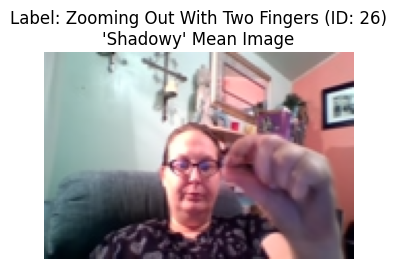

In [127]:
show_random_baseline_image(baseline_data_valid)